In [1]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt

data_dir = os.path.abspath("")
data_file = 'automobile.csv'
df = pd.read_csv(os.path.join(data_dir,data_file))
# all data tweaking will use df_data instead of original df
# for data safty reason
df_data = df.copy()

df.sample(5)

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
55,3,150.0,mazda,gas,std,two,hatchback,rwd,front,95.3,...,80,mpfi,?,?,9.4,135,6000,16,23,15645
19,0,81.0,chevrolet,gas,std,four,sedan,fwd,front,94.5,...,90,2bbl,3.03,3.11,9.6,70,5400,38,43,6575
198,-1,95.0,volvo,gas,std,four,sedan,rwd,front,109.1,...,173,mpfi,3.58,2.87,8.8,134,5500,18,23,21485
52,3,150.0,mazda,gas,std,two,hatchback,rwd,front,95.3,...,70,4bbl,?,?,9.4,101,6000,17,23,10945
108,0,161.0,peugot,gas,std,four,sedan,rwd,front,107.9,...,120,mpfi,3.46,2.19,8.4,95,5000,19,24,15580


# dealing with missing data
1. data interpolation or refilling
2. entire column dropping

# finding data collinearity
1. correlation
2. f or chi-square test

## raw data scrutiny

In [2]:
from collections import Counter
for x in df:
    c = Counter(df[x])
    print(df[x].name, ":\t", df[x].dtypes, "\t-", c.most_common(3))

symboling :	 int64 	- [(0, 65), (1, 52), (2, 32)]
normalized-losses :	 float64 	- [(161.0, 11), (91.0, 8), (150.0, 7)]
make :	 object 	- [('toyota', 32), ('nissan', 18), ('mazda', 17)]
fuel-type :	 object 	- [('gas', 182), ('diesel', 20)]
aspiration :	 object 	- [('std', 165), ('turbo', 37)]
num-of-doors :	 object 	- [('four', 114), ('two', 86), (nan, 2)]
body-style :	 object 	- [('sedan', 95), ('hatchback', 68), ('wagon', 25)]
drive-wheels :	 object 	- [('fwd', 118), ('rwd', 76), ('4wd', 8)]
engine-location :	 object 	- [('front', 199), ('rear', 3)]
wheel-base :	 float64 	- [(93.7, 20), (94.5, 19), (95.7, 13)]
length :	 float64 	- [(157.3, 15), (188.8, 12), (186.7, 7)]
width :	 float64 	- [(63.8, 24), (66.5, 23), (65.4, 15)]
height :	 float64 	- [(50.8, 14), (55.7, 12), (54.5, 10)]
curb-weight :	 int64 	- [(2385, 4), (1989, 3), (1918, 3)]
engine-type :	 object 	- [('ohc', 146), ('ohcf', 15), ('ohcv', 13)]
num-of-cylinders :	 object 	- [('four', 158), ('six', 24), ('five', 10)]
engine-

In [3]:
# change all non-numeric data into one-hot coding
# note that some numeric data are stored in str form due to missing value
from collections import Counter
import re 

col_lists = []
for col in df:
    if df[col].values.dtype == "object":  
        col_lists.append(col)
        c = Counter(df[col])
        print(df[col].name, df[col][0], len(c.items()))
print(col_lists)

make alfa-romero 22
fuel-type gas 2
aspiration std 2
num-of-doors two 3
body-style convertible 5
drive-wheels rwd 3
engine-location front 2
engine-type dohc 6
num-of-cylinders four 7
fuel-system mpfi 8
bore 3.47 39
stroke 2.68 37
horsepower 111 59
peak-rpm 5000 23
['make', 'fuel-type', 'aspiration', 'num-of-doors', 'body-style', 'drive-wheels', 'engine-location', 'engine-type', 'num-of-cylinders', 'fuel-system', 'bore', 'stroke', 'horsepower', 'peak-rpm']


## data preprocessing

### transfer num-words to number

In [4]:
# find that "num-of-cylinders" and "num-of-doors" features could be transferred from word to number.
def trans_word_to_num(df, col_name):
    word_dat = df[col_name].values
    for index, item in enumerate(word_dat):
        if item == "one":
            word_dat[index] = 1
        elif item == "two":
            word_dat[index] = 2
        elif item == "three":
            word_dat[index] = 3
        elif item == "four":
            word_dat[index] = 4
        elif item == "five":
            word_dat[index] = 5
        elif item == "six":
            word_dat[index] = 6
        elif item == "seven":
            word_dat[index] = 7
        elif item == "eight":
            word_dat[index] = 8
        elif item == "night":
            word_dat[index] = 9
        elif item == "ten":
            word_dat[index] = 10
        elif item == "eleven":
            word_dat[index] = 11
        elif item == "twelve":
            word_dat[index] = 12
        else:
            word_dat[index] = np.nan
    return pd.Series(data=word_dat, name=col_name)

In [5]:
col_list0 = ["num-of-cylinders", "num-of-doors" ]
for col_name0 in col_list0:
    col_res = trans_word_to_num(df_data, col_name0)
    col_res.fillna(col_res.median(),inplace=True)
    df_data.drop(labels=col_name0, axis=1, inplace=True)
    pd.concat([col_res, df_data], axis=1)

### transfer object-stored number to number

In [6]:
# find that some numbers are stored in object type
def trans_object_to_num(df, col_name):
    """
    transfer some object data into float
    """
    res = []
    for i in df[col_name]:
        if re.search(r'[0-9]',str(i)):
            res.append(float(i))
        else:
            res.append(np.nan)
    return pd.Series(np.array(res,np.float64),name=col_name)

In [7]:
from sklearn.impute import SimpleImputer

# transfer string into numeric number
# then replace missing data with median of series
col_list1 = ["bore","stroke","horsepower","peak-rpm"]
for col_name1 in col_list1:
    temp_series = trans_object_to_num(df_data,col_name1)
    df_data[col_name1] = temp_series
    df_data[col_name1].fillna(df_data[col_name].median(),inplace=True)

### transfer non-numeric feature into one-hot pattern

In [8]:
# at last transfer non-numeric features into one-hot pattern
from sklearn.preprocessing import OneHotEncoder

def trans_object_to_onehot(df, col_name):
    onehot_enc = OneHotEncoder()
    oh_res = onehot_enc.fit_transform(df[col_name].values.reshape(-1,1))
    col_names = []
    for cat in onehot_enc.categories_:
        col_names.append(col_name + '-' + cat)
    return pd.DataFrame(data=np.array(oh_res.toarray(), dtype=np.int64), columns=col_names)

In [9]:
col_list2 = ['make', 'fuel-type', 'aspiration', 
            'body-style', 'drive-wheels', 'engine-location', 
            'engine-type', 'fuel-system']

for col_name2 in col_list2:
    temp_df = trans_object_to_onehot(df_data,col_name2)
    df_data.drop(labels=col_name2, axis=1, inplace=True)
    df_data = pd.concat([df_data,temp_df],axis=1)

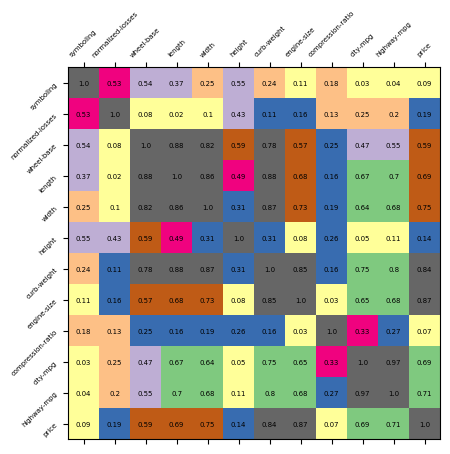

In [22]:
# correlation between target and features
df_corr = df.copy()
for x in df:
    if df[x].dtype not in (np.int64, np.float64):
        df_corr.drop(labels=x, axis=1, inplace=True)
df_corr_res = df_corr.corr()

plt.matshow(df_corr_res, cmap=plt.cm.Accent)
for x_pos in range(len(df_corr_res)):
    for y_pos in range(len(df_corr_res)):
        plt.text(x_pos, y_pos, np.abs(np.round(df_corr_res.iloc[x_pos,y_pos],2)),
                 va='center',ha='center',fontsize=5)
plt.xticks(np.arange(0,len(df_corr_res.columns),1),labels=df_corr_res.columns,rotation=45,fontsize=5)
plt.yticks(np.arange(0,len(df_corr_res.columns),1),labels=df_corr_res.columns,rotation=45,fontsize=5)
plt.minorticks_on
plt.show()

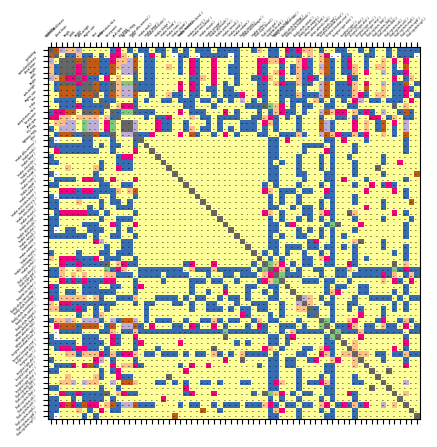

In [23]:
# correlation between target and features
df_corr = df_data.copy()
df_corr_res = df_corr.corr()

plt.matshow(df_corr_res, cmap=plt.cm.Accent)
for x_pos in range(len(df_corr_res)):
    for y_pos in range(len(df_corr_res)):
        plt.text(x_pos, y_pos, np.abs(np.round(df_corr_res.iloc[x_pos,y_pos],2)),
                 va='center',ha='center',fontsize=1)
plt.xticks(np.arange(0,len(df_corr_res.columns),1),labels=df_corr_res.columns,rotation=45,fontsize=2)
plt.yticks(np.arange(0,len(df_corr_res.columns),1),labels=df_corr_res.columns,rotation=45,fontsize=2)
plt.minorticks_on
plt.show()

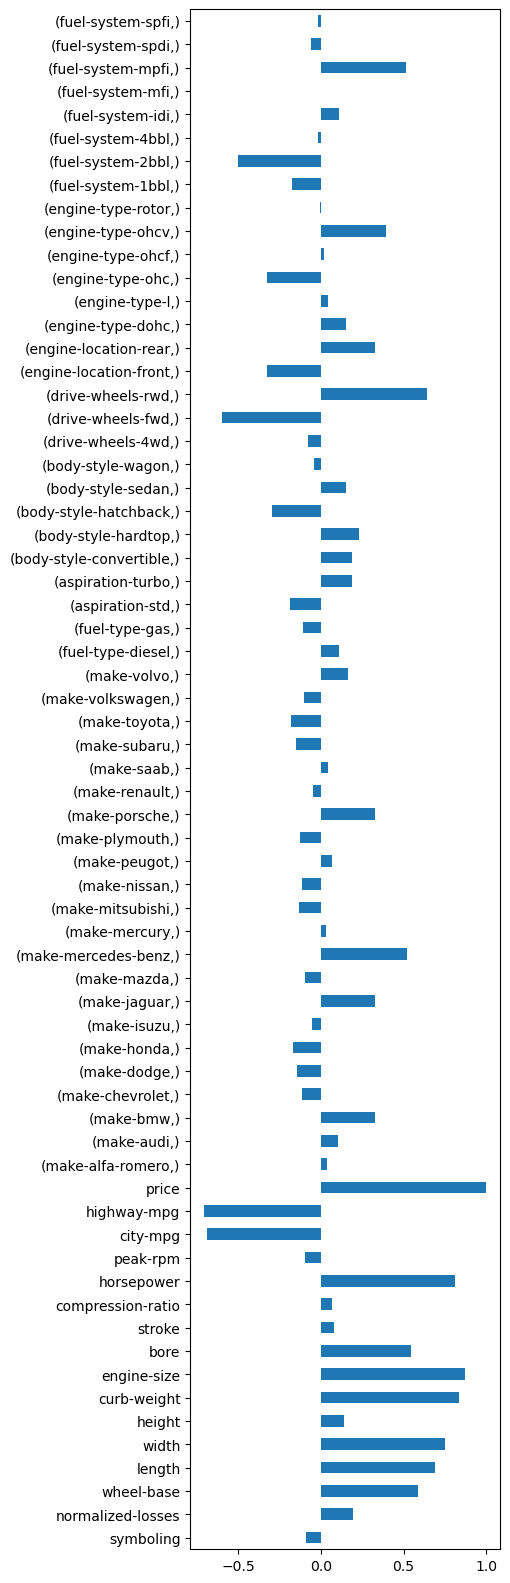

In [17]:
df_data.corr().loc["price"].plot(kind='barh',figsize=(4,20))
plt.show()